In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from skimage.io import imshow

from IPython.display import display
tf.__version__

'2.3.0'

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()


In [3]:
type(train_images)

numpy.ndarray

In [4]:
train_images.dtype, train_images.shape

(dtype('uint8'), (60000, 28, 28))

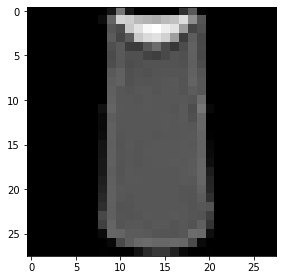

In [5]:
imshow(train_images[2])

In [6]:
def img_to_float(img):
  return (np.float32(img)-127.5)/127.5
def img_to_uint8(img):
  return np.uint8(img*127.5+128).clip(0, 255)

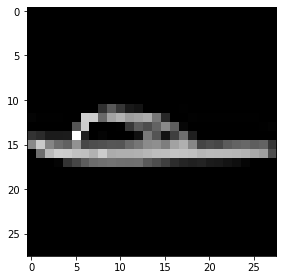

In [7]:
train_img_f32 = img_to_float(train_images)
imshow(img_to_uint8(train_img_f32[30]))

In [8]:
type(train_img_f32)

numpy.ndarray

In [9]:
BUFFER_SIZE = train_img_f32.shape[0]
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(train_img_f32).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [22]:
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose, Conv2D
latent_dim = 64
generator = tf.keras.Sequential([
    Dense(256, use_bias=False, input_shape=(latent_dim,)),
    BatchNormalization(),
    LeakyReLU(),
    Dense(512),
    BatchNormalization(),
    LeakyReLU(),
    Dense(1024),
    BatchNormalization(),
    LeakyReLU(),
    Dense(np.prod((28,28,1)), activation='tanh'),
    Reshape((28, 28, 1))
]
)

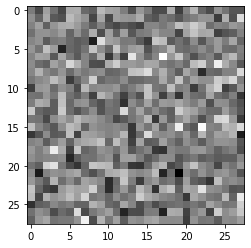

In [23]:
noise = tf.random.normal([BATCH_SIZE, latent_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [24]:
from tensorflow.keras.layers import Conv2D, Dropout, Flatten
discriminator =  tf.keras.Sequential([
    Dense(512, use_bias=False, input_shape=((28,28,1))),
    LeakyReLU(),
    Dense(512),
    LeakyReLU(),
    Dense(512),
    LeakyReLU(),
    Dense(1 , activation='sigmoid'),
    Flatten(),
    Dense(1)]
)

In [25]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(generated_output):
    return loss_fn(tf.ones_like(generated_output), generated_output)

In [26]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = loss_fn(tf.ones_like(real_output), real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = loss_fn(tf.zeros_like(generated_output), generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
EPOCHS = 50
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 latent_dim])

In [18]:
@tf.function
def train_step(images):
   # generating noise from a normal distribution
      noise = tf.random.normal([BATCH_SIZE, latent_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      return gen_loss, disc_loss

In [19]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap= None)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [28]:
for epoch in range(30):
  start_time = time.time()
  loss = []
  for images in train_dataset:
      loss.append(np.array(train_step(images)))
  fake = generator(random_vector_for_generation, training=False)
  fake_concat = np.transpose(img_to_uint8(fake), [1,0,2,3]).reshape((32,-1,3))

  generate_and_save_images(generator,
                             epoch + 1,
                             random_vector_for_generation)
  print(epoch, np.mean(loss, axis=0), time.time()-start_time)
  
  display(PIL.Image.fromarray(fake_concat))
  
generate_and_save_images(generator,
                             epoch ,
                             random_vector_for_generation) 

ValueError: in user code:

    <ipython-input-18-1218ae696fb0>:9 train_step  *
        real_output = discriminator(images, training=True)
    C:\Users\Doffy\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\Doffy\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_4 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape [32, 28, 28]
